<a href='https://ai.meng.duke.edu'> = <img align="left" style="padding-top:10px;" src=https://storage.googleapis.com/aipi_datasets/Duke-AIPI-Logo.png>

# Artificial Neurons and Neural Networks
This notebook includes implementations of artificial neurons (Perceptron, Adaline & Logistic Regression) and simple neural networks from scratch in Python.

1) [The Perceptron](#artificial-neuron-1-the-perceptron)
2) [Adaline](#artificial-neuron-2-adaline)
3) [Logistic Regression](#artificial-neuron-3-logistic-regression)
4) [Binary Classification with NLL Loss and ReLu activation](#binary-classification-with-nll-loss-and-relu-activation)
5) [Binary Classification with NLL Loss and Sigmoid activation](#binary-classification-with-nll-loss-and-sigmoid-activation)
6) [Multiclass Classification with Cross Entropy Loss](#multiclass-classification-with-cross-entropy-loss)
7) [Multiclass Classification with Cross Entropy Loss and L2 Regularization](#multiclass-classification-with-cross-entropy-loss-and-l2-regularization)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings("ignore")

In [4]:
from sklearn.datasets import load_breast_cancer
data=load_breast_cancer(as_frame=True)
X,y=data.data,data.target
# Since the default in the file is 0=malignant 1=benign we want to reverse these
y=(y==0).astype(int)
X,y= np.array(X),np.array(y)

# Let's set aside a test set and use the remainder for training and cross-validation
X_train,X_test,y_train,y_test = train_test_split(X, y, random_state=0,test_size=0.2)

data.data.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [5]:
# Let's scale our data to help speed convergence
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Artificial Neurons
### Artificial Neuron 1: The Perceptron

In [10]:
class Perceptron:
    
    def __init__(self,eta=0.01,n_iter=100,random_state=0):
        self.eta=eta
        self.n_iter=n_iter
        self.random_state=random_state
        self.cost_path=[]
    
    def fit(self,X,y):
        # Initialize the weights and bias (weights[0]) to small random numbers
        rgen=np.random.RandomState(self.random_state)
        self.weights = rgen.normal(loc=0.0,scale=0.01,size=(1+X.shape[1]))
        
        # Train the perceptron using stochastic gradient descent
        for i in range(self.n_iter):
            # Keep track of cost for each iteration
            cost_total = 0
            # Stochastic gradient descent
            for xi,yi in zip(X,y):
                # Get prediction
                yhat = self.predict(xi)
                # Calculate cost function - SSE
                error = yi-yhat
                cost = 0.5*(error)**2
                gradient_weights = error*xi
                gradient_bias = error*1
                # Update rule
                delta_weights = self.eta * gradient_weights
                delta_bias = self.eta * gradient_bias
                # Update the weights
                self.weights[1:] += delta_weights
                # Update bias
                self.weights[0] += delta_bias
                # Count errors
                cost_total+= cost
            #self.error_counts.append(error_count)
            self.cost_path.append(cost_total)
        return self
    
    def predict(self,X):
        z = np.dot(X,self.weights[1:]) + self.weights[0]
        if z >= 0.0:
            yhat = 1
        else:
            yhat = 0
        return yhat

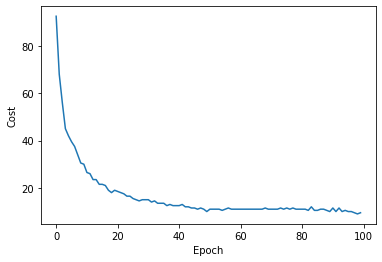

In [21]:
random_state = 123
perceptron_model = Perceptron(eta=0.00001,n_iter=100, random_state=random_state)
perceptron_model.fit(X_train_scaled,y_train)
plt.plot(range(len(perceptron_model.cost_path)),perceptron_model.cost_path)
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.show()

In [22]:
test_preds = []
for x in X_test_scaled:
    pred = perceptron_model.predict(x)
    test_preds.append(pred)
test_acc = np.sum(test_preds==y_test)/len(y_test)
print('Test set accuracy is {:.3f}'.format(test_acc))

Test set accuracy is 0.930


### Artificial Neuron 2: Adaline

In [23]:
class Adaline:
    
    def __init__(self,eta=0.01,n_iter=100,random_state=0):
        self.eta=eta
        self.n_iter=n_iter
        self.random_state=random_state
        self.cost_path=[]
    
    def fit(self,X,y):
        # Initialize the weights and bias (weights[0]) to small random numbers
        rgen=np.random.RandomState(self.random_state)
        self.weights = rgen.normal(loc=0.0,scale=0.01,size=(1+X.shape[1]))
        
        # Train adaline using batch gradient descent
        for i in range(self.n_iter):
            yhat = self.predict(X)
            # Calculate the cost and gradient of cost with respect to weights and bias
            cost = np.sum(0.5 * (y-yhat)**2)
            gradient_weights = X.T.dot(y-yhat)
            gradient_bias = np.sum(y-yhat)
            # Update weights and bias
            delta_weights = self.eta * gradient_weights
            delta_bias = self.eta * gradient_bias
            self.weights[1:] += delta_weights # Update weights
            self.weights[0] += delta_bias # Update bias
            # Add cost to total cost counter
            self.cost_path.append(cost)
        return self
    
    def predict(self,X):
        z = np.dot(X,self.weights[1:]) + self.weights[0]
        yhat = 1*z
        return yhat

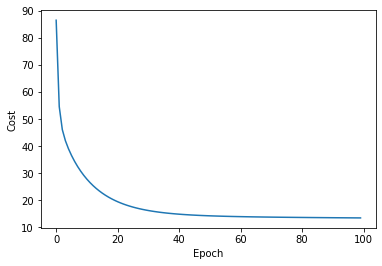

In [24]:
adaline_model = Adaline(eta=0.0001,n_iter=100, random_state=random_state)
adaline_model.fit(X_train_scaled,y_train)
plt.plot(range(len(adaline_model.cost_path)),adaline_model.cost_path)
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.show()

In [25]:
test_preds = adaline_model.predict(X_test_scaled)
test_preds = np.round(test_preds)
test_acc = np.sum(test_preds==y_test)/len(y_test)
print('Test set accuracy is {:.3f}'.format(test_acc))

Test set accuracy is 0.921


### Artificial Neuron 3: Logistic Regression

In [29]:
class LogisticRegressionGD:
    
    def __init__(self,eta=0.01,n_iter=100,random_state=0):
        self.eta=eta
        self.n_iter=n_iter
        self.random_state=random_state
        self.cost_path=[]
    
    def fit(self,X,y):
        # Initialize the weights and bias (weights[0]) to small random numbers
        rgen=np.random.RandomState(self.random_state)
        self.weights = rgen.normal(loc=0.0,scale=0.01,size=(1+X.shape[1]))
        
        # Train adaline using batch gradient descent
        for i in range(self.n_iter):
            yhat = self.predict(X)
            # Calculate the cost and gradient of cost with respect to weights and bias
            cost = (-y.dot(np.log(yhat)) - ((1-y).dot(np.log(1-yhat))))
            gradient_weights = -X.T.dot(y-yhat) # Gradient of cost wrt weights
            gradient_bias = -np.sum(y-yhat) # Gradient of cost wrt bias
            
            # Update the weights and bias
            delta_weights = self.eta * gradient_weights
            delta_bias = self.eta * gradient_bias
            self.weights[1:] -= delta_weights # Update weights
            self.weights[0] -= delta_bias # Update bias
            # Add cost to total cost counter
            self.cost_path.append(cost)
        return self
    
    def predict(self,X):
        z = np.dot(X,self.weights[1:]) + self.weights[0]
        yhat = 1. / (1. + np.exp(-np.clip(z,-250,250)))
        return yhat

In [30]:
logreg_model = LogisticRegressionGD(eta=0.001,n_iter=100)
logreg_model.fit(X_train_scaled,y_train)
plt.plot(range(len(logreg_model.cost_path)),logreg_model.cost_path)
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.show()

[0.48221005 0.49506913 0.50378299 0.48395065 0.49639885 0.48945631
 0.49724208 0.48265285 0.52720648 0.47742749 0.56068877 0.4882357
 0.50107175 0.47454399 0.47176473 0.48472162 0.53235254 0.47206088
 0.4847832  0.5049186  0.49092736 0.47919815 0.5138422  0.50849531
 0.58497686 0.48037759 0.4858168  0.47565637 0.54847535 0.49241959
 0.48251534 0.55644608 0.49656175 0.52646904 0.48813937 0.49286579
 0.4956916  0.50294803 0.4817548  0.49674755 0.47576135 0.51157192
 0.49643811 0.50965801 0.48906745 0.52005685 0.55351679 0.48833725
 0.49181133 0.53349087 0.48521811 0.51942949 0.50827839 0.5280197
 0.49848518 0.50136937 0.47437475 0.47916391 0.47169325 0.49371856
 0.52598464 0.45217373 0.46924736 0.49092808 0.47491363 0.51138508
 0.54661792 0.48790204 0.50769394 0.51082893 0.4788     0.47965782
 0.49820959 0.48335245 0.54517268 0.48066148 0.47093849 0.53002896
 0.51080306 0.47602809 0.4745856  0.53833777 0.56767813 0.49566797
 0.49047272 0.52066223 0.49682846 0.47154772 0.52034854 0.569037

KeyboardInterrupt: Interrupted by user

In [28]:
test_preds = logreg_model.predict(X_test_scaled)
test_preds = np.round(test_preds)
test_acc = np.sum(test_preds==y_test)/len(y_test)
print('Test set accuracy is {:.3f}'.format(test_acc))

Test set accuracy is 0.956


## Shallow Neural Networks from Scratch
### Binary Classification with NLL Loss and ReLu activation
Shallow neural network for binary classification with one hidden layer and an output layer.  Network uses Negative Log Likelihood cost function and ReLu as the activation function of the hidden layer.

In [14]:
class NeuralNet_NLL_relu:
    
    def __init__(self,eta=0.05,n_iter=100,hidden_size=100,random_state=0):
        self.eta=eta # Learning rate
        self.n_iter=n_iter # Number of epochs
        self.hidden_size=hidden_size # Number of units in the hidden layer
        self.random_state=random_state
    
    def predict(self,X):
        # Feed data through the neural network to get z scores of output
        z_hidden = np.dot(X, self.W_1) + self.b_1
        hiddenlayer_output = np.maximum(0, z_hidden) # linear combination plus relu
        z_out = np.dot(hiddenlayer_output, self.W_out) + self.b_out # Output layer
        yhat = 1. / (1. + np.exp(-z_out))
        return yhat
    
    def fit(self,X,y):
        epsilon = 1e-10
        N = X.shape[0] # Number of observations
        P = X.shape[1] # Number of features
        
        # Initialize the weights and biases to small random numbers
        self.W_1 = 0.01 * np.random.randn(P,self.hidden_size) # Weights layer 1
        self.b_1 = np.zeros((1,self.hidden_size)) # Biases layer 1
        self.W_out = 0.01 * np.random.randn(self.hidden_size,1) # Weights in output layer
        self.b_out = np.zeros((1,1)) # Bias in output layer
        
        # Train using batch gradient descent
        for i in range(self.n_iter):
            # Forward propagation to get the predictions
            yhat = self.predict(X)
            # Compute the average NLL loss
            cost = 1/N*(-y.dot(np.log(yhat+epsilon)) - ((1-y).dot(np.log(1-yhat+epsilon))))
            if i % 1000 == 0:
                print("iteration {:d}: loss {:.5f}".format(i, cost.item()))
            
            # Backpropagation

            # Calculate the gradient of the average NLL loss with respect to output layer
            gradient_z_out = -1/N*(y.reshape(-1,1)-yhat)
            hiddenlayer_output = np.maximum(0, np.dot(X, self.W_1) + self.b_1) # linear combination plus relu
            gradient_W_out = np.dot(hiddenlayer_output.T,gradient_z_out) # Gradient wrt output layer weights
            gradient_b_out = np.sum(gradient_z_out) # Gradient wrt output layer bias
            
            # Backpropagate to hidden layer output
            gradient_hidden_output = np.dot(gradient_z_out,self.W_out.T) # Hidden layer error
            # Backpropagate back through relu to hidden layer z
            grad_relu = np.ones(shape=gradient_hidden_output.shape) 
            grad_relu[hiddenlayer_output <=0]=0  # Gradient of hidden layer output wrt ReLu
            gradient_z_hidden = gradient_hidden_output * grad_relu # Gradient of hidden layer wrt z_hidden
            # Backpropagate to W_1 and b_1
            gradient_W_1 = np.dot(X.T,gradient_z_hidden) # Gradient wrt weights layer 1
            gradient_b_1 = np.sum(gradient_z_hidden,axis=0) # Gradient wrt biases layer 1
            
            # Update the weights and biases
            self.W_1 -= self.eta * gradient_W_1
            self.b_1 -= self.eta * gradient_b_1
            self.W_out -= self.eta * gradient_W_out
            self.b_out -= self.eta * gradient_b_out
        
        return self

In [15]:
nn_model = NeuralNet_NLL_relu(eta=0.05,n_iter=10000)
nn_model.fit(X_train_scaled,y_train)

# evaluate test set accuracy
yhat = nn_model.predict(X_test_scaled).squeeze()
yhat = (yhat>=0.5).astype(int)
acc = np.sum(yhat.reshape(-1)==y_test)/len(y_test)

print('Test set accuracy: {:.3f}'.format(acc))

iteration 0: loss 0.69296
iteration 1000: loss 0.05362
iteration 2000: loss 0.04102
iteration 3000: loss 0.03294
iteration 4000: loss 0.02720
iteration 5000: loss 0.02270
iteration 6000: loss 0.01916
iteration 7000: loss 0.01636
iteration 8000: loss 0.01409
iteration 9000: loss 0.01213
Test set accuracy: 0.965


### Binary Classification with NLL Loss and sigmoid activation
Shallow neural network for binary classification with one hidden layer and an output layer.  Network uses Negative Log Likelihood cost function and sigmoid function as the activation function of the hidden layer.

In [12]:
class NeuralNet_NLL_sigmoid:
    
    def __init__(self,eta=0.05,n_iter=100,hidden_size=100,random_state=0):
        self.eta=eta # Learning rate
        self.n_iter=n_iter # Number of epochs
        self.hidden_size=hidden_size # Number of units in the hidden layer
        self.random_state=random_state
    
    def predict(self,X):
        ### BEGIN SOLUTION ###
        # Feed data through the neural network to get z scores of output
        z_hidden = np.dot(X, self.W_1) + self.b_1
        hiddenlayer_output = 1. / (1. + np.exp(-z_hidden))
        z_out = np.dot(hiddenlayer_output, self.W_out) + self.b_out # Output layer
        yhat = 1. / (1. + np.exp(-z_out))
        ### END SOLUTION ###
        return yhat
    
    def fit(self,X,y):
        epsilon = 1e-10
        N = X.shape[0] # Number of observations
        P = X.shape[1] # Number of features
        
        # Initialize the weights and biases to small random numbers
        self.W_1 = 0.01 * np.random.randn(P,self.hidden_size) # Weights layer 1
        self.b_1 = np.zeros((1,self.hidden_size)) # Biases layer 1
        self.W_out = 0.01 * np.random.randn(self.hidden_size,1) # Weights in output layer
        self.b_out = np.zeros((1,1)) #Bias in output layer
        
        # Train using batch gradient descent
        for i in range(self.n_iter):
            ### BEGIN SOLUTION ###
            
            # Forward propagation to get the predictions
            yhat = self.predict(X)
            
            # Compute the average NLL loss
            cost = 1/N*(-y.dot(np.log(yhat+epsilon)) - ((1-y).dot(np.log(1-yhat+epsilon))))
            if i % 1000 == 0:
                print("iteration {:d}: loss {:.5f}".format(i, cost.item()))
            
            # Backpropagation
            # Calculate the gradient of the average NLL loss with respect to output layer weights and bias
            gradient_z_out = -1/N*(y.reshape(-1,1)-yhat)
            hiddenlayer_output = 1. / (1. + np.exp(-(np.dot(X, self.W_1) + self.b_1)))
            gradient_W_out = np.dot(hiddenlayer_output.T,gradient_z_out)
            gradient_b_out = np.sum(gradient_z_out)
            
            # Backpropagate to hidden layer output
            gradient_hidden_output = np.dot(gradient_z_out,self.W_out.T)
            # Backpropagate through sigmoid to hidden layer z
            gradient_z_hidden = gradient_hidden_output * (hiddenlayer_output * (1-hiddenlayer_output))
            # Backpropagate to W_1 and b_1
            gradient_W_1 = np.dot(X.T,gradient_z_hidden) # Gradient of cost wrt weights layer 1
            gradient_b_1 = np.sum(gradient_z_hidden,axis=0) # Gradient of cost wrt biases layer 1
            
            # Update the weights and biases
            self.W_1 -= self.eta * gradient_W_1
            self.b_1 -= self.eta * gradient_b_1
            self.W_out -= self.eta * gradient_W_out
            self.b_out -= self.eta * gradient_b_out
        
        ### END SOLUTION ###
        return self

In [16]:
nn_model = NeuralNet_NLL_sigmoid(eta=0.3,n_iter=10000)
nn_model.fit(X_train_scaled,y_train)

# evaluate test set accuracy
yhat = nn_model.predict(X_test_scaled).squeeze()
yhat = (yhat>=0.5).astype(int)
acc = np.sum(yhat.reshape(-1)==y_test)/len(y_test)

print('Test set accuracy: {:.3f}'.format(acc))

iteration 0: loss 0.68694
iteration 1000: loss 0.05184
iteration 2000: loss 0.04564
iteration 3000: loss 0.04211
iteration 4000: loss 0.03927
iteration 5000: loss 0.03626
iteration 6000: loss 0.03263
iteration 7000: loss 0.02842
iteration 8000: loss 0.02422
iteration 9000: loss 0.02043
Test set accuracy: 0.974


### Multiclass Classification with Cross Entropy Loss
Even though we only have two classes, we can implement a neural network for multiclass classificaiton using a softmax layer to get the output probabilities.  Since we use a softmax rather than a sigmoid (as we usually do in binary classification), the below implementation uses cross entropy as the loss function (rather than NLL).  An explanation of the math behind the cross entropy loss function and its gradient can be found [here](http://machinelearningmechanic.com/deep_learning/2019/09/04/cross-entropy-loss-derivative.html)

In [10]:
class NeuralNet_CrossEntropy:
    
    def __init__(self,eta=0.01,n_iter=100,hidden_size=100,random_state=0):
        self.eta=eta # Learning rate
        self.n_iter=n_iter # Number of epochs
        self.hidden_size=hidden_size # Number of units in the hidden layer
        self.random_state=random_state
    
    def fit(self,X,y):
        
        N = X.shape[0] # Number of observations
        P = X.shape[1] # Number of features
        out_classes = len(np.unique(y)) # Number of classes in y
        
        # Initialize the weights to small random numbers
        self.W1 = 0.01 * np.random.randn(P,self.hidden_size)
        self.b1 = np.zeros((1,self.hidden_size))
        self.W2 = 0.01 * np.random.randn(self.hidden_size,out_classes)
        self.b2 = np.zeros((1,out_classes))
        
        # Train using batch gradient descent
        for i in range(self.n_iter):
            
            # Get the predictions
            yhat = self.predict(X)
            
            # Compute the average cross-entropy loss
            # Avg cross-entropy loss: 1/N * (-log(probability of correct class (y)))
            correct_logprobs = -np.log(yhat[range(N),y])
            loss = 1/N*np.sum(correct_logprobs)
            if i % 1000 == 0:
                print("iteration {:d}: loss {:.5f}".format(i, loss))
            
            # Calculate the gradient of the average cross-entropy loss with respect to z_out
            # Gradient = 1/size * (yhat - p(x)), where p(x) is the one-hot encoded vector of y
            # E.g. if y = 0 and 3 classes, p(x)=[1,0,0]. If y=2, p(x) = [0,0,1]
            gradient = yhat.copy()
            gradient[range(N),y] = gradient[range(N),y] - 1
            gradient *= 1/N # Get the average over all observations in batch
            
            # Backpropate the gradient to the parameters
            # First backprop to get gradient with respect to W2 and b2 (weights between hidden layer and output)
            hiddenlayer_output = np.maximum(0, np.dot(X, self.W1) + self.b1) # linear combination plus relu
            dW2 = np.dot(hiddenlayer_output.T, gradient)
            db2 = np.sum(gradient, axis=0, keepdims=True)
            
            # Calculate hidden layer error term
            hidden_error = np.dot(gradient, self.W2.T)
            # Backpropagate the ReLU non-linearity
            hidden_error[hiddenlayer_output <= 0] = 0
            # Backprop to get gradient wrt W1 and b1
            dW1 = np.dot(X.T, hidden_error)
            db1 = np.sum(hidden_error, axis=0, keepdims=True)
            
            # Update the weights and biases
            self.W1 += -self.eta * dW1
            self.b1 += -self.eta * db1
            self.W2 += -self.eta * dW2
            self.b2 += -self.eta * db2
            
        return self
    
    def predict(self,X):
        # Feed data through the neural network to get z scores of output
        hiddenlayer_output = np.maximum(0, np.dot(X, self.W1) + self.b1) # First hidden layer incl. relu
        z_out = np.dot(hiddenlayer_output, self.W2) + self.b2 # Output layer
        # Compute the class probabilities from the z scores using softmax function
        yhat = np.exp(z_out) / np.sum(np.exp(z_out), axis=1, keepdims=True) # Shape: (num_examples,num_classes)
        return yhat


nn_model = NeuralNet_CrossEntropy(eta=0.05,n_iter=20000)
nn_model.fit(X_train_scaled,y_train)

# evaluate test set accuracy
yhat = nn_model.predict(X_test_scaled)
predicted_class = np.argmax(yhat, axis=1)
print('Test set accuracy: {:.3f}'.format(np.mean(predicted_class == y_test)))

iteration 0: loss 0.69400
iteration 1000: loss 0.04781
iteration 2000: loss 0.03386
iteration 3000: loss 0.02544
iteration 4000: loss 0.01966
iteration 5000: loss 0.01547
iteration 6000: loss 0.01234
iteration 7000: loss 0.00998
iteration 8000: loss 0.00818
iteration 9000: loss 0.00683
iteration 10000: loss 0.00578
iteration 11000: loss 0.00494
iteration 12000: loss 0.00427
iteration 13000: loss 0.00373
iteration 14000: loss 0.00328
iteration 15000: loss 0.00291
iteration 16000: loss 0.00261
iteration 17000: loss 0.00235
iteration 18000: loss 0.00213
iteration 19000: loss 0.00194
Test set accuracy: 0.974


### Multiclass Classification with Cross Entropy Loss and L2 Regularization
Implementation of the above network which includes L2 regularization together with cross entropy as the loss function.

In [21]:
class NeuralNetwithRegularization:
    
    def __init__(self,eta=0.01,n_iter=100,hidden_size=100,reg=1e-3,random_state=0):
        self.eta=eta # Learning rate
        self.n_iter=n_iter # Number of epochs
        self.hidden_size=hidden_size # Number of units in the hidden layer
        self.reg=1e-3 # Regularization penalty
        self.random_state=random_state
    
    def fit(self,X,y):
        
        N = X.shape[0] # Number of observations
        P = X.shape[1] # Number of features
        out_classes = len(np.unique(y)) # Number of classes in y
        
        # Initialize the weights to small random numbers
        self.W1 = 0.01 * np.random.randn(P,self.hidden_size)
        self.b1 = np.zeros((1,self.hidden_size))
        self.W2 = 0.01 * np.random.randn(self.hidden_size,out_classes)
        self.b2 = np.zeros((1,out_classes))
        
        # Train using batch gradient descent
        for i in range(self.n_iter):
            
            # Get the predictions
            yhat = self.predict(X)
            
            # Compute the total average loss = 1/N * (cross-entropy loss + regularization loss)
            # Cross-entropy loss: (-log(normalized probability of correct class))
            # Regularization loss: 0.5 * reg * sum of weights squared, across all features and classes
            correct_logprobs = -np.log(yhat[range(N),y])
            data_loss = np.sum(correct_logprobs)
            reg_loss = 0.5*self.reg*np.sum(self.W1*self.W1) + 0.5*self.reg*np.sum(self.W2*self.W2)
            loss = 1/N * (data_loss + reg_loss)
            if i % 1000 == 0:
                print("iteration {:d}: loss {:.5f}".format(i, loss))
            
            # Calculate the gradient of the average cross-entropy loss
            # Gradient = 1/size * (yhat - p(x)), where p(x) is the one-hot encoded vector of y
            # E.g. if y = 0 and 3 classes, p(x)=[1,0,0]. If y=2, p(x) = [0,0,1]
            gradient = yhat.copy()
            gradient[range(N),y] = gradient[range(N),y] - 1
            gradient *= 1/N # Get the average over all observations in batch
            
            # Backpropate the gradient to the parameters
            # First backprop to get gradient wrt W2 and b2
            hidden_layer = np.maximum(0, np.dot(X, self.W1) + self.b1) # linear combination plus relu
            dW2 = np.dot(hidden_layer.T, gradient)
            db2 = np.sum(gradient, axis=0, keepdims=True)
            
            # Calculate hidden layer error term
            hidden_error = np.dot(gradient, self.W2.T)
            # Backpropagate the ReLU non-linearity
            hidden_error[hidden_layer <= 0] = 0
            # Backprop to get gradient wrt W1 and b1
            dW1 = np.dot(X.T, hidden_error)
            db1 = np.sum(hidden_error, axis=0, keepdims=True)
            
            # Add regularization gradient contribution to the gradients
            dW2 += 1/N * (self.reg * self.W2)
            dW1 += 1/N * (self.reg * self.W1)
            
            # Update the weights and biases
            self.W1 += -self.eta * dW1
            self.b1 += -self.eta * db1
            self.W2 += -self.eta * dW2
            self.b2 += -self.eta * db2
            
        return self
    
    def predict(self,X):
        # Feed data through the neural network to get z scores of output
        hidden_layer = np.maximum(0, np.dot(X, self.W1) + self.b1) # First hidden layer incl. relu
        out_scores = np.dot(hidden_layer, self.W2) + self.b2 # Output layer
        # Compute the class probabilities from the z scores using softmax function
        yhat = np.exp(out_scores) / np.sum(np.exp(out_scores), axis=1, keepdims=True) # Shape: (num_examples,num_classes)
        return yhat


nn_model = NeuralNetwithRegularization(eta=0.05,reg=1e-3, n_iter=20000)
nn_model.fit(X_train_scaled,y_train)

iteration 0: loss 0.69106
iteration 1000: loss 0.04660
iteration 2000: loss 0.03258
iteration 3000: loss 0.02440
iteration 4000: loss 0.01890
iteration 5000: loss 0.01490
iteration 6000: loss 0.01202
iteration 7000: loss 0.00986
iteration 8000: loss 0.00822
iteration 9000: loss 0.00695
iteration 10000: loss 0.00594
iteration 11000: loss 0.00513
iteration 12000: loss 0.00447
iteration 13000: loss 0.00392
iteration 14000: loss 0.00347
iteration 15000: loss 0.00309
iteration 16000: loss 0.00277
iteration 17000: loss 0.00250
iteration 18000: loss 0.00227
iteration 19000: loss 0.00208


In [22]:
# evaluate test set accuracy
yhat = nn_model.predict(X_test_scaled)
predicted_class = np.argmax(yhat, axis=1)
print('Test accuracy: {:.3f}'.format(np.mean(predicted_class == y_test)))

Test accuracy: 0.991
